In [1]:
import pyro
import torch
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

def model():
    pass

def guide():
    pass

adam_params = {"lr": 0.005, "betas": (0.95, 0.999)}
optim = Adam(adam_params)

svi = SVI(model, guide, optim, loss=Trace_ELBO())

The up block is a demo for pyro SVI. And the following is a simple example for how to use pyro to inference the fairness of flipping a coin

# SVI part I: define the model and guide

In [2]:
import pyro.distributions as dist

def model(data):
    # define the hyperparameters that control the Beta prior
    alpha0 = torch.tensor(10.0)
    beta0 = torch.tensor(10.9)
    # sample f from the Beta prior
    f = pyro.sample("latent_fairness", dist.Beta(alpha0, beta0))
    # loop over the observed data
    for i in range(len(data)):
        # observe datapoint i using the bernoulli
        # likelihood Bernoulli(f)
        pyro.sample("obs_{}".format(i), dist.Bernoulli(f), obs=data[i])
        # pyro.observe("obs_{}".format(i), dist.Bernoulli(f), data[i])

A corresponding guide, i.e. an appropriate variational distribution for the latent random variable $f$.  
The only real requirement is that $q(f)$ should be probability distribution over the range $[0.0, 1.0]$, since $f$ doesn't make sense outside of that range.  
A simple choice is to use another Beta distribution, with parameters $\alpha_q$ and $\beta_q$. Actually, in this particular case this is the 'right' choice, since conjugacy of the Bernoulli and Beta distributions means that the exact posterior is a Beta distribution.

In [3]:
import torch.distributions.constraints as constraints
# the constraint ensures that alpha_q > 0, and that beta_q > 0, so that the posterior is well-defined.

def guide(data):
    # register the two variational parameters with Pyro.
    alpha_q = pyro.param("alpha_1", torch.tensor(15.0),
                         constraint=constraints.positive)
    beta_q = pyro.param("beta_1", torch.tensor(15.0),
                        constraint=constraints.positive)
    # sample the latent variable f from the distribution Beta(alpha_q, beta_q)
    pyro.sample("latent_fairness", dist.Beta(alpha_q, beta_q))

1. Some thing should be noted that: The names of the random variables line up exactly between the model and guide.  
2. `model(data)` and `guide(data)` take the same argument  
3. The variational parameters are `torch.tensor`s. The `requires_grad` flag is automatically set to `True` when we call `pyro.param()`.
4. `constraint=constraints.positive` to ensure that the variational parameters are positive.

In [4]:
# set up the optimizer
adam_params = {"lr": 0.0005, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

n_steps = 5000

# do gradient steps
for step in range(n_steps):
    svi.step(data)

In [6]:
import math
import os
import torch
import torch.distributions.constraints as constraints
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist

smoke_test = ('CI' in os.environ)
n_steps = 2 if smoke_test else 2000

# clear the param store in case we're in a REPL
pyro.clear_param_store()

# create some data with 6 observed heads and 9 observed tails
data = []
for _ in range(6):
    data.append(torch.tensor(1.0))
for _ in range(9):
    data.append(torch.tensor(0.))

def model(data):
    # define the hyperparameters that control the Beta prior
    alpha0 = torch.tensor(10.0)
    beta0 = torch.tensor(10.0)
    # sample f from the Beta prior
    f = pyro.sample("latent_fairness", dist.Beta(alpha0, beta0))
    # loop over the observed data
    for i in range(len(data)):
        # observe datapoint i using the bernoulli
        # likelihood Bernoulli(f)
        pyro.sample("obs_{}".format(i), dist.Bernoulli(f), obs=data[i])
        # pyro.observe("obs_{}".format(i), dist.Bernoulli(f), data[i])

def guide(data):
    # register the two variational parameters with Pyro
    alpha_q = pyro.param("alpha_q", torch.tensor(15.0),
                            constraint=constraints.positive)
    beta_q = pyro.param("beta_q", torch.tensor(15.0),
                            constraint=constraints.positive)
    # sample the latent variable f from the distribution Beta(alpha_q, beta_q)
    pyro.sample("latent_fairness", dist.Beta(alpha_q, beta_q))

# setup the optimizer
adam_params = {"lr": 0.0005, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

# do gradient steps
for step in range(n_steps):
    svi.step(data)
    if step % 100 == 0:
        print('.', end='')

# grab the learned variational parameters
alpha_q = pyro.param("alpha_q").item()
beta_q = pyro.param("beta_q").item()

# calculate the inferred mean of the Beta posterior
inferred_mean = alpha_q / (alpha_q + beta_q)
# calculate the inferred standard deviation of the Beta posterior
factor = beta_q / (alpha_q * (1.0 + alpha_q + beta_q))
inferred_std = inferred_mean * math.sqrt(factor)

print(f"\n\n\nBased on the data and our prior belief, the fairness of the coin is {inferred_mean:.3f} " + 
      f"with a standard deviation of {inferred_std:.3f}")

....................
 Based on the data and our prior belief, the fairness of the coin is 0.461 with a standard deviation of 0.089


# SVI II: conditional independence, subsampling, and amortization

The Goal: Scaling SVI to large Datasets

The log likelihood term in the ELBO can be approximated with
$$ \Sigma_{i=1}^N \log p(x_i|z) \approx \frac{N}{M} \Sigma_{i \in I_M} \log p(x_i|z) $$
where $I_M$ is a minibatch of size $M$ drawn uniformly at random from $\{1, \ldots, N\}$.

## Marking Conditional Independence in Pyro

Pyro provides two language primitives for marking conditional independence: `plate` and `markov`.

### Sequential `plate`

In [ ]:
def model(data):
    f = pyro.sample("latent_fairness", dist.Beta(alpha0, beta0))
    for i in pyro.plate("data_loop", len(data)):
        pyro.sample("obs_{}".format(i), dist.Bernoulli(f), obs=data[i])

The `pyro.plate` is very similar to `range` with one main difference: each invocation of `plate` requires 
the user to provide a unique name. The second argument is an integer just like for `range`.  


Each observed `sample` statement occurs within a different execution of the body of the `plate` loop, 
Pyro marks each observation as independent

### Vectorized `plate`

In [ ]:
data = torch.zeros(10)
data[0:6] = torch.ones(6)

with pyro.plate("observe_data"):
    pyro.sample("obs", dist.Bernoulli(f), obs=data)

## Subsampling
Depending on the structure of the model and guide, Pyro supports several ways of doing subsampling
### Automatic subsampling with `plate`

In [ ]:
# sequential enumeration
for i in pyro.plate("data_loop", len(data), subsample_size=5):
    pyro.sample("obs_{}".format(i), dist.Bernoulli(f), obs=data[i])

In [ ]:
# vectorized enumeration
with pyro.plate("observe_data", size=100, subsample_size=5) as ind:
    pyro.sample("obs", dist.Bernoulli(f), obs=data.index_select(0, ind))

`plate` now returns a tensor of indices `ind`.  

Since this subsampling is stateless, this can lead to some problems: basically for a sufficiently large dataset even after a large number of iterations there’s a nonnegligible probability that some of the datapoints will have never been selected.

### Custom subsampling strategies with `plate`

#### Subsampling when there are only local random variables
A joint probability density given by $$ p(x,z) = \prod_{i=1}^N p(x_i|z_i)p(z_i) $$
For a model with this dependency structure the scale factor introduced by subsampling scales all the terms in the ELBO by the same amount. This is the case, for example, for a vanilla VAE. This explains why for the VAE it’s permissible for the user to take complete control over subsampling and pass mini-batches directly to the model and guide

#### Subsampling when there are both global and local random variables
Consider the model specified by the following joint distribution: $$ p(x,z,\beta) = p(\beta) \prod_{i=1}^N p(x_i|z_i)p(z_i|\beta) $$
There are N observations, and N local latent random variables. There is also a global latent random variable $\beta$.  
Our guide is a factorized distribution: $$ q(z,\beta) = q(\beta) \prod_{i=1}^N q(z_i|\beta,\lambda_i) $$

# SVI III: ELBO Gradient Estimation

## Variance or Why I with I was Doing MLE deep learning
### Reducting Variance Via Dependency Structure

$\log{p_\theta(x|\text{Pa}_p(x))} + \sum_i\log{p_\theta(z_i|\text{Pa}_p(z_i))}-\sum_i\log{q_\phi(z_i|\text{Pa}_q(z_i))}$



In [3]:
svi = SVI(model, guide, optimizer, TraceGraph_ELBO()) 
# `TraceGraph_ELBO` should only be used in the case where your model has non-reparameterizable random variables.

In [2]:
ks = pyro.sample("k", dist.Categorical(probs).to_event(1))
pyro.sample("obs", dist.Normal(locs[ks], scales[ks]).to_event(1), obs=data)

# mark conditional independence
with pyro.plate("foo", data.size(-1)):
    ks = pyro.sample("k", dist.Categorical(probs))
    pyro.sample("obs", dist.Normal(locs[ks], scales[ks]), obs=data)

2

## Reducing Variance with Data-Dependent Baselines
### Decaying Average Baseline

In [ ]:
z = pyro.sample("z", dist.Bernoulli(...), infer=dict(baseline={"use_decaying_avg_baseline": True,
                                                     'baseline_beta': 0.95}))

### Neural Baselines

In [ ]:
class BaselineNN(nn.Modele):
    def __init__(self, dim_input, dim_hidden):
        super().__init__()
        self.linear = nn.Linear(dim_input, dim_hidden)
    
    def forward(self, x):
        hidden = self.linear(x)
        # ... do something with hidden ...
        return baseline

In [ ]:
def guide(x):
    pyro.module("my_baseline", baseline_model)
    # ... do something with x ...
    z = pyro.sample("z", dist.Bernoulli(...),
                    infer=dict(baseline={'nn_baseline': baseline_model,
                                         'nn_baseline_input': x}))

In [ ]:
def per_param_args(param_name):
    if 'baseline' in param_name:
        return {"lr": 0.010}
    else:
        return {"lr": 0.001}

optimizer = Adam(per_param_args)

In [ ]:
# use argument baseline_value
b = # do baseline computation
z = pyro.sample("z", dist.Bernoulli(...), infer=dict(baseline={"baseline_value": b}))

In [2]:
import os
import torch
import torch.distributions.constraints as constraints
import pyro
import pyro.distributions as dist

# Pyro also has a reparameterized Beta distribution so we import the non-reparameterized version to make our point
from pyro.distributions.testing.fakes import NonreparameterizedBeta
import pyro.optim as optim
from pyro.infer import SVI, TraceGraph_ELBO
import sys

assert pyro.__version__.startswith("1.8")

In [3]:
# this is for running the notebook in our testing framework
smoke_test = ('CI' in os.environ)
max_steps = 2 if smoke_test else 10000

def param_abs_error(name, target):
    return torch.sum(torch.abs(target - pyro.param(name))).item()

class BernoulliBetaExample:
    def __init__(self, max_steps):
        self.max_steps = max_steps
        # two hyperparameters for the prior Beta distribution
        self.alpha0 = 10.0
        self.beta0 = 10.0
        # the datasets consists of six 1s and four 0s
        self.data = torch.zeros(10)
        self.data[0:6] = torch.ones(6)
        self.n_data = self.data.size(0)
        # compute the alpha parameter of the exact beta posterior
        self.alpha_n = self.data.sum() + self.alpha0
        # compute the beta parameter of the exact beta posterior
        self.beta_n = -self.data.sum() + torch.tensor(self.beta0 + self.n_data)
        # initial values of the two variational parameters
        self.alpha_q_0 = 15.0
        self.beta_q_0 = 15.0

    def model(self, use_decaying_avg_baseline):
        # sample `latent_fairness` from the beta prior
        f = pyro.sample("latent_fairness", dist.Beta(self.alpha0, self.beta0))
        # use plate to indicate that the observations are
        # conditionally independent given f and get vectorization
        with pyro.plate("data_plate"):
            # observe all ten datapoints using the bernoulli likelihood
            pyro.sample("obs", dist.Bernoulli(f), obs=self.data)

    def guide(self, use_decaying_avg_baseline):
        # register the two variational parameters with pyro
        alpha_q = pyro.param("alpha_q", torch.tensor(self.alpha_q_0),
                             constraint=constraints.positive)
        beta_q = pyro.param("beta_q", torch.tensor(self.beta_q_0),
                            constraint=constraints.positive)
        # sample f from the beta variational distribution
        baseline_dict = {'use_decaying_avg_baseline': use_decaying_avg_baseline,
                         'baseline_beta': 0.90}
        # note that the baseline_dict specifies whether we're using
        # decaying average baselines or not
        pyro.sample("latent_fairness", NonreparameterizedBeta(alpha_q, beta_q),
                    infer=dict(baseline=baseline_dict))

    def do_inference(self, use_decaying_avg_baseline, tolerance=0.80):
        # clear the param store in case we're in a REPL
        pyro.clear_param_store()
        # setup the optimizer and the inference algorithm
        optimizer = optim.Adam({"lr": .0005, "betas": (0.93, 0.999)})
        svi = SVI(self.model, self.guide, optimizer, loss=TraceGraph_ELBO())
        print("Doing inference with use_decaying_avg_baseline=%s" % use_decaying_avg_baseline)

        # do up to this many steps of inference
        for k in range(self.max_steps):
            svi.step(use_decaying_avg_baseline)
            if k % 100 == 0:
                print('.', end='')
                sys.stdout.flush()

            # compute the distance to the parameters of the true posterior
            alpha_error = param_abs_error("alpha_q", self.alpha_n)
            beta_error = param_abs_error("beta_q", self.beta_n)

            # stop inference early if we're close to the true posterior
            if alpha_error < tolerance and beta_error < tolerance:
                break

        print("\nDid %d steps of inference." % k)
        print(("Final absolute errors for the two variational parameters " +
               "were %.4f & %.4f") % (alpha_error, beta_error))

# do the experiment
bbe = BernoulliBetaExample(max_steps=max_steps)
bbe.do_inference(use_decaying_avg_baseline=True)
bbe.do_inference(use_decaying_avg_baseline=False)

Doing inference with use_decaying_avg_baseline=True
..
Did 152 steps of inference.
Final absolute errors for the two variational parameters were 0.7981 & 0.7786
Doing inference with use_decaying_avg_baseline=False
...
Did 216 steps of inference.
Final absolute errors for the two variational parameters were 0.7998 & 0.7395


# SVI IV: Tips and Tricks
The effect of all this machinery is to cast Bayesian Inference as a *Stochastic Optimization Problem*

1. Start with a small learning rate
```{python}
optimizer = pyro.optim.Adam({"lr": 0.001})
```
2. Use Adam or ClippedAdam by default
Tune the pair of `betas` hyperparameters to control the amount of momentum used by `Adam`.
```{python}
betas = (0.95, 0.999)
```
instead of 
```{python}
betas = (0.90, 0.999)
```
3. Consider using a decaying learning rate
```{python}
num_steps = 1000
initial_lr = 0.001
gamma = 0.1 # final_lr will be gamma * initial_lr
lrd = gamma ** (1.0 / num_steps)
optim = pyro.optim.ClippedAdam({"lr": initial_lr, "lrd": lrd})
```

4. Make sure your model and guide distributions have the same support
```{python}
def model():
    pyro.sample("x", dist.LogNormal(0., 1.))
```
```{python}
def good_guide():
    loc = pyro.param("loc", torch.tensor(0.))
    pyro.sample("x", dist.LogNormal(loc, 1.))

def bad_guide():
    loc = pyro.param("loc", torch.tensor(0.))
    pyro.sample("x", dist.Normal(loc, 1.)) # Normal may have negative support
```

5. Constrain parameters that need to be constrained
```{python}
def bad_guide():
    scale = pyro.param("scale", torch.tensor(1.))
    pyro.sample("x", dist.Normal(0., scale)) # scale may be negative

from pyro.distributions import constraints
def good_guide():
    scale = pyro.param("scale", torch.tensor(0.05), constraint=constraints.positive)
    pyro.sample("x", dist.Normal(0., scale))
```

6. If you are having trouble constructing a custom guide, use an AutoGuide
Easy guide `init_lof_fn`
7. Parameter initialization matters: initialize guide distributions to have low variance
```{python}
from pyro.distriutions import constraints
def good_guide():
    scale = pyro.param("scale", torch.tensor(0.05), constraint=constraints.positive)
    pyro.sample("x", dist.Normal(0., scale))

def bad_guide():
    scale = pyro.param("scale", torch.tensor(12345.6), constraint=constraints.positive)
    pyro.sample("x", dist.Normal(0., scale))
```

8. Explore trade-offs controlled by `num_particles`, mini-batch size, etc.
```{python}
elbo = pyro.infer.Trace_ELBO(num_particles=10, vectorize_particles=True)
```
It’s usually worth taking more gradient steps with fewer particles than fewer gradient steps with more particles.

9. Use `TraceMeanField` if applicable
When analytic KL diverences are available, you may be able to lower ELBO variance by using analytic KL divergences instead.
10. Consider normalizing your ELBO
By default Pyro computes a un-normalized ELBO, i.e. it computes the quantity that is a lower bound to the log evidence computed on the full set of data that is being conditioned on. 
11. Pay attention to scales
They matter for at least two important reasons:   
    i. scales can make or break a particular initialization scheme;   
    ii. as discussed in the previous section, scales can have an impact on numerical precision and stability.  
```{python}
pyro.sample("W", dist.Normal(torch.zeros(2), torch.ones(2)))

# instead of
prior_scale = torch.tensor([1.0e-5, 1.0e-2])
pyro.sample("W", dist.Normal(torch.zeros(2), prior_scale))
```
12. Keep validation enabled
```{python}
strict_enumeration_warning=True
```
13. Tensor shape errors
14. Enumerate discrete latent variables if possible
15. Some complex models can benefit from KL annealing
It can help to anneal the relevant strength of the KL divergence term during optimization

16. Consider clipping gradients or constraining parameters defensively
`concentration` and `rate` parameters that defines a Gamma distribution may exhibit such sensitivity.
```{python}
concentration = pyro.param("concentration", torch.tensor(0.5), constraint.greater_than(0.001))
```

# Bayesian Regression

In [4]:
import os
from functools import partial
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist

pyro.set_rng_seed(1)

%matplotlib inline
plt.style.use('default')

Dataset 

`rugged`: quantifies the Terrain Ruggedness Index   
`cont_africa`: whether the given nation is in Africa  
`rgdppc_2000`: Real GDP per capita for the year 2000  

In [5]:
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

In [6]:
df

,cont_africa,rugged,rgdppc_2000
2,1,0.858,7.492609
4,0,3.427,8.216929
7,0,0.769,9.933263
8,0,0.775,9.407032
9,0,2.688,7.792343
...,...,...,...
229,0,1.677,8.488849
230,0,2.323,6.669180
231,1,1.761,9.150497
232,1,0.533,6.651585


[Text(0.5, 0, 'Terrain Ruggedness Index'),
 Text(0, 0.5, 'log GDP (2000)'),
 Text(0.5, 1.0, 'African Nations')]

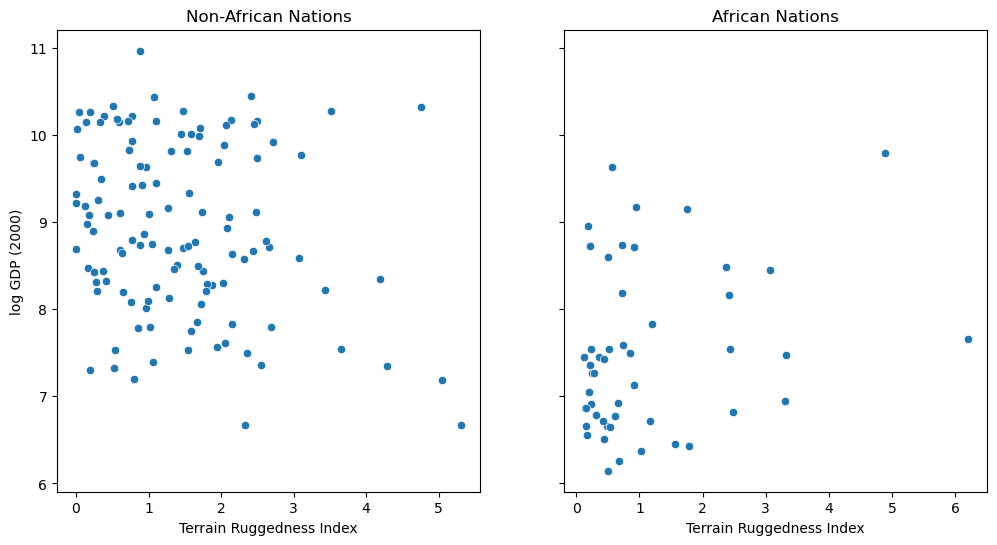

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
african_nations = df[df["cont_africa"] == 1]
non_african_nations = df[df["cont_africa"] == 0]
sns.scatterplot(x=non_african_nations["rugged"], y=non_african_nations["rgdppc_2000"], ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)", title="Non-African Nations")
sns.scatterplot(x=african_nations["rugged"], y=african_nations["rgdppc_2000"], ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)", title="African Nations")

In [8]:
from torch import nn
from pyro.nn import PyroModule

assert issubclass(PyroModule[nn.Linear], nn.Linear)
assert issubclass(PyroModule[nn.Linear], PyroModule)

In [9]:
# Dataset: Add a feature to capture the interaction between "cont_africa" and "rugged"
df["cont_africa_x_rugged"] = df["cont_africa"] * df["rugged"]
data = torch.tensor(df[['cont_africa', 'rugged', 'cont_africa_x_rugged', 'rgdppc_2000']].values, dtype=torch.float)
x_data, y_data = data[:, :-1], data[:, -1]

# Regression model
linear_reg_model = PyroModule[nn.Linear](3, 1)

# Define the loss and optimize
loss_fn = torch.nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(linear_reg_model.parameters(), lr=0.05)
num_iterations = 1500 if not smoke_test else 2

def train():
    # run the model forward on the data
    y_pred = linear_reg_model(x_data).squeeze(-1)
    # calculate the mse loss
    loss = loss_fn(y_pred, y_data)
    # initialize gradients to zero
    optim.zero_grad()
    # backpropagate
    loss.backward()
    # take a gradient step
    optim.step()
    return loss

for j in range(num_iterations):
    loss = train()
    if (j+1) % 50 == 0:
        print(f"[iteration {j+1}] loss: {loss.item():.2f}")

# Inspect learned parameters
print("Learned parameters:")
for name, param in linear_reg_model.named_parameters():
    print(name, param.data.numpy())

[iteration 50] loss: 3179.79
[iteration 100] loss: 1616.14
[iteration 150] loss: 1109.41
[iteration 200] loss: 833.75
[iteration 250] loss: 637.58
[iteration 300] loss: 488.27
[iteration 350] loss: 376.47
[iteration 400] loss: 296.05
[iteration 450] loss: 240.61
[iteration 500] loss: 203.94
[iteration 550] loss: 180.62
[iteration 600] loss: 166.35
[iteration 650] loss: 157.95
[iteration 700] loss: 153.18
[iteration 750] loss: 150.57
[iteration 800] loss: 149.20
[iteration 850] loss: 148.51
[iteration 900] loss: 148.17
[iteration 950] loss: 148.01
[iteration 1000] loss: 147.93
[iteration 1050] loss: 147.90
[iteration 1100] loss: 147.89
[iteration 1150] loss: 147.88
[iteration 1200] loss: 147.88
[iteration 1250] loss: 147.88
[iteration 1300] loss: 147.88
[iteration 1350] loss: 147.88
[iteration 1400] loss: 147.88
[iteration 1450] loss: 147.88
[iteration 1500] loss: 147.88
Learned parameters:
weight [[-1.9478593  -0.20278622  0.39330277]]
bias [9.22308]


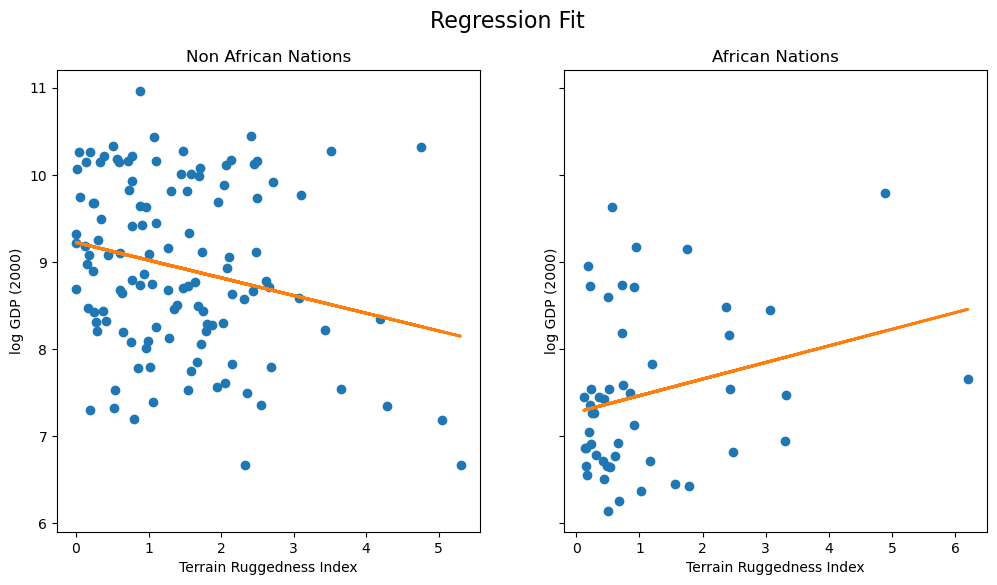

In [10]:
fit = df.copy()
fit["mean"] = linear_reg_model(x_data).detach().cpu().numpy()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = fit[fit["cont_africa"] == 1]
non_african_nations = fit[fit["cont_africa"] == 0]
fig.suptitle("Regression Fit", fontsize=16)
ax[0].plot(non_african_nations["rugged"], non_african_nations["rgdppc_2000"], "o")
ax[0].plot(non_african_nations["rugged"], non_african_nations["mean"], linewidth=2)
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
ax[1].plot(african_nations["rugged"], african_nations["rgdppc_2000"], "o")
ax[1].plot(african_nations["rugged"], african_nations["mean"], linewidth=2)
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

# Bayesian Regression with Pyro's SVI

In [11]:
from pyro.nn import PyroSample

class BayesianRegression(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        self.linear.weight = PyroSample(dist.Normal(0., 1.).expand([out_features, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 10.).expand([out_features]).to_event(1))

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

In [12]:
from pyro.infer.autoguide import AutoDiagonalNormal

model = BayesianRegression(3, 1)
guide = AutoDiagonalNormal(model) # Assume that there is no correlation amongst the latent variables

In [13]:
from pyro.infer import SVI, Trace_ELBO

adam = pyro.optim.Adam({"lr": 0.03})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

In [14]:
pyro.clear_param_store()
for j in range(num_iterations):
    # calcualte the loss and take a gradient step
    loss = svi.step(x_data, y_data)
    if j % 100 == 0:
        print(f"[Iteration {j+1:04d}] loss: {loss:.4f}")

[Iteration 0001] loss: 1059.2693
[Iteration 0101] loss: 599.5718
[Iteration 0201] loss: 550.4127
[Iteration 0301] loss: 524.7316
[Iteration 0401] loss: 448.3655
[Iteration 0501] loss: 350.4925
[Iteration 0601] loss: 252.5525
[Iteration 0701] loss: 248.7282
[Iteration 0801] loss: 248.7519
[Iteration 0901] loss: 248.0613
[Iteration 1001] loss: 253.9684
[Iteration 1101] loss: 254.8113
[Iteration 1201] loss: 253.9341
[Iteration 1301] loss: 249.5398
[Iteration 1401] loss: 247.8685


In [15]:
guide.requires_grad_(False)

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

AutoDiagonalNormal.loc Parameter containing:
tensor([-2.2371, -1.8097, -0.1691,  0.3790,  9.1824])
AutoDiagonalNormal.scale tensor([0.0552, 0.1143, 0.0387, 0.0769, 0.0700])


In [16]:
guide.quantiles([0.25, 0.5, 0.75])

{'sigma': tensor([0.9327, 0.9647, 0.9976]),
 'linear.weight': tensor([[[-1.8868, -0.1952,  0.3272]],
 
         [[-1.8097, -0.1691,  0.3790]],
 
         [[-1.7325, -0.1430,  0.4309]]]),
 'linear.bias': tensor([[9.1351],
         [9.1824],
         [9.2296]])}

In [17]:
from pyro.infer import Predictive

def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(0.05 * v.shape[0]), dim=0)[0],
            "95%": v.kthvalue(int(0.95 * v.shape[0]), dim=0)[0],
        }
    return site_stats

predictive = Predictive(model, guide=guide, num_samples=800, return_sites=("linear.weight","obs", "_RETURN"))
samples = predictive(x_data)
pred_summary = summary(samples)

In [18]:
mu = pred_summary["_RETURN"]
y = pred_summary["obs"]
predictions = pd.DataFrame({
    "cont_africa": x_data[:, 0],
    "rugged": x_data[:, 1],
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_gdp": y_data,
})

[Text(0.5, 0, 'Terrain Ruggedness Index'),
 Text(0, 0.5, 'log GDP (2000)'),
 Text(0.5, 1.0, 'African Nations')]

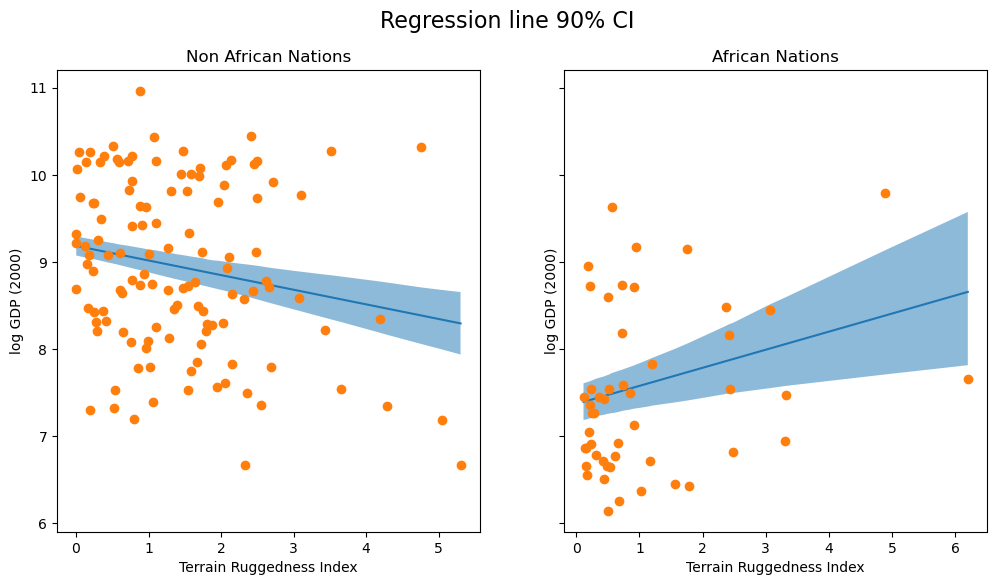

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = predictions[predictions["cont_africa"] == 1]
non_african_nations = predictions[predictions["cont_africa"] == 0]
african_nations = african_nations.sort_values(by=["rugged"])
non_african_nations = non_african_nations.sort_values(by=["rugged"])
fig.suptitle("Regression line 90% CI", fontsize=16)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["mu_mean"])
ax[0].fill_between(non_african_nations["rugged"],
                   non_african_nations["mu_perc_5"],
                   non_african_nations["mu_perc_95"],
                   alpha=0.5)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["true_gdp"],
           "o")
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
idx = np.argsort(african_nations["rugged"])
ax[1].plot(african_nations["rugged"],
           african_nations["mu_mean"])
ax[1].fill_between(african_nations["rugged"],
                   african_nations["mu_perc_5"],
                   african_nations["mu_perc_95"],
                   alpha=0.5)
ax[1].plot(african_nations["rugged"],
           african_nations["true_gdp"],
           "o")
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations")

[Text(0.5, 0, 'Terrain Ruggedness Index'),
 Text(0, 0.5, 'log GDP (2000)'),
 Text(0.5, 1.0, 'African Nations')]

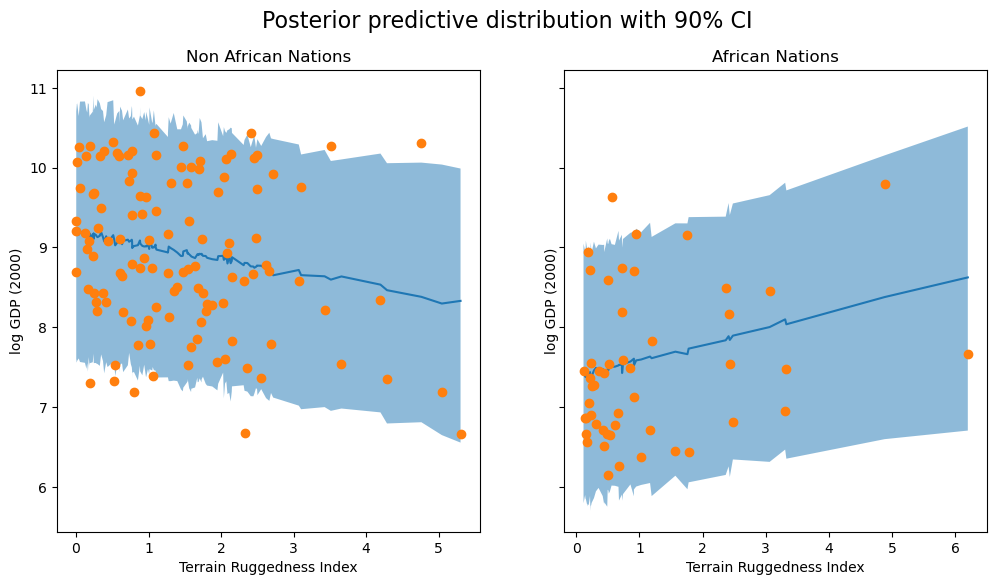

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
fig.suptitle("Posterior predictive distribution with 90% CI", fontsize=16)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["y_mean"])
ax[0].fill_between(non_african_nations["rugged"],
                   non_african_nations["y_perc_5"],
                   non_african_nations["y_perc_95"],
                   alpha=0.5)
ax[0].plot(non_african_nations["rugged"],
              non_african_nations["true_gdp"],  "o")
ax[0].set(xlabel="Terrain Ruggedness Index",
            ylabel="log GDP (2000)",
            title="Non African Nations")
idx = np.argsort(african_nations["rugged"])
ax[1].plot(african_nations["rugged"],
              african_nations["y_mean"])
ax[1].fill_between(african_nations["rugged"],
                    african_nations["y_perc_5"],
                    african_nations["y_perc_95"],
                    alpha=0.5)
ax[1].plot(african_nations["rugged"],
                african_nations["true_gdp"],  "o")
ax[1].set(xlabel="Terrain Ruggedness Index",
            ylabel="log GDP (2000)",
            title="African Nations")

/home/dell/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/dell/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


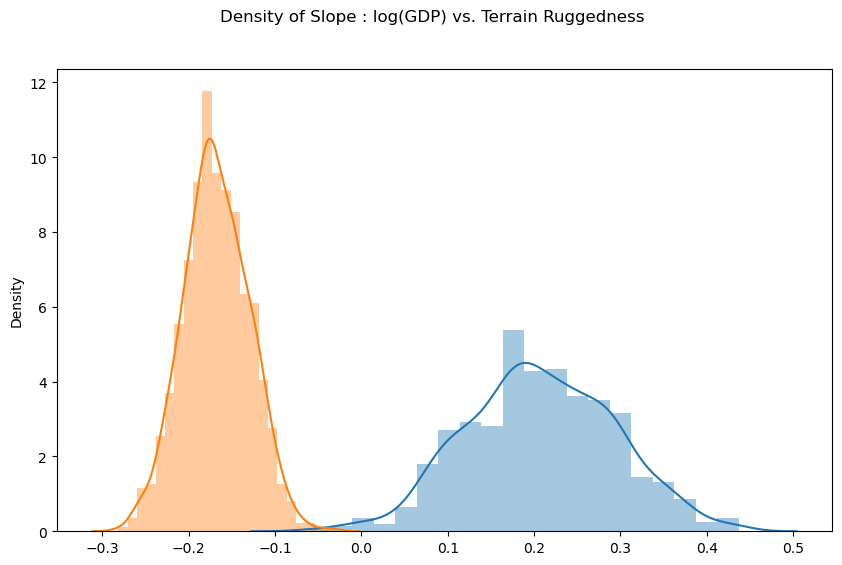

In [21]:
weight = samples["linear.weight"]
weight = weight.reshape(weight.shape[0], 3)
gamma_within_africa = weight[:, 1] + weight[:, 2]
gamma_outside_africa = weight[:, 1]
fig = plt.figure(figsize=(10, 6))
sns.distplot(gamma_within_africa, kde_kws={"label": "African nations"},)
sns.distplot(gamma_outside_africa, kde_kws={"label": "Non-African nations"})
fig.suptitle("Density of Slope : log(GDP) vs. Terrain Ruggedness");

In [25]:
weight

tensor([[-1.9329, -0.1825,  0.2462],
        [-2.0556, -0.1823,  0.4028],
        [-1.9188, -0.1547,  0.3439],
        ...,
        [-1.6174, -0.1584,  0.2641],
        [-1.7088, -0.0954,  0.2760],
        [-1.7608, -0.0828,  0.4546]])

Model Serving via TorchScript

In [26]:
from collections import defaultdict
from pyro import poutine
from pyro.poutine.util import prune_subsample_sites
import warnings

class Predict(torch.nn.Module):
    def __init__(self, model, guide):
        super().__init__()
        self.model = model
        self.guide = guide
    
    def forward(self, *args, **kwargs):
        samples = {}
        guide_trace = poutine.trace(self.guide).get_trace(*args, **kwargs)
        model_trace = poutine.trace(poutine.replay(self.model, trace=guide_trace)).get_trace(*args, **kwargs)
        for site in prune_subsample_sites(model_trace).stochastic_nodes:
            samples[site] = model_trace.nodes[site]["value"]
        return tuple(v for _,v in sorted(samples.items()))
    
predict_fn = Predict(model, guide)
# torch.jit.trace_module to trace the forward method of this module and save it using torch.jit.save
predict_module = torch.jit.trace_module(predict_fn, {"forward": (x_data,)}, check_trace=False)

In [27]:
torch.jit.save(predict_module, "/home/wuxinchao/data/project/pMHC-TCR/ckpt/reg_predict.pt")
pred_loaded = torch.jit.load("/home/wuxinchao/data/project/pMHC-TCR/ckpt/reg_predict.pt")
pred_loaded(x_data)

(tensor([9.2164]),
 tensor([[-1.6610, -0.1498,  0.4282]]),
 tensor([ 7.5952,  8.2472,  9.3863,  9.2589,  9.0538,  9.3914,  8.6763,  9.3774,
          9.5471,  9.6144, 10.3520,  8.5453,  5.4010,  8.4600,  9.6217,  9.7772,
          7.1957,  7.2580,  8.9158,  9.0874,  8.3729,  8.7902,  9.3166,  8.8156,
          7.4434,  9.9980,  8.6907,  9.2914, 10.1375,  7.7619, 10.1916,  7.4755,
          6.3474,  7.7584,  9.1307,  6.0795,  8.5640,  7.8485,  9.2827,  9.0762,
          7.9251, 10.9224,  8.0004, 10.1797,  5.3612,  8.1173,  8.0586,  8.5098,
          6.8656,  8.6764,  7.8926,  9.5232, 10.1267, 10.2660,  7.8884,  8.9193,
         10.2864,  7.0823,  8.2370,  8.3088,  7.8409,  8.4892,  8.0106,  7.6814,
          8.7496,  9.3549,  9.9685, 10.4802,  8.5175,  7.1678, 10.8803,  7.4918,
          8.7087,  9.2416,  9.2359,  9.7906,  8.4933,  7.8896,  9.5337,  9.6571,
          9.6602,  9.9853,  6.7416,  8.1719, 10.0645, 10.0816,  8.4501,  9.2587,
          8.4487,  7.7514,  6.8496,  9.2207,  8.98

/home/dell/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/dell/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0.98, 'Loaded TorchScript Module : log(GDP) vs. Terrain Ruggedness')

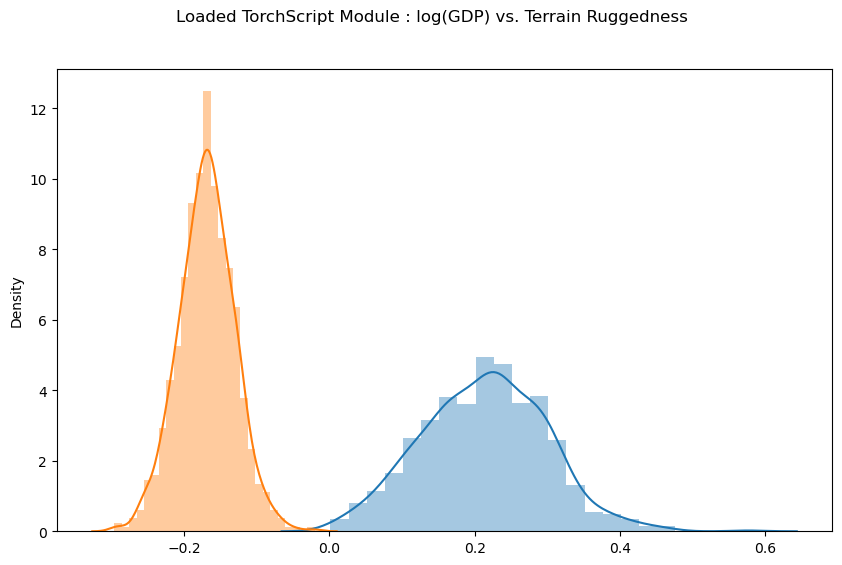

In [28]:
weight = []
for _ in range(800):
    # index = 1 corresponds to "linear.weight"
    weight.append(pred_loaded(x_data)[1])
weight = torch.stack(weight).detach()
weight = weight.reshape(weight.shape[0], 3)
gamma_within_africa = weight[:, 1] + weight[:, 2]
gamma_outside_africa = weight[:, 1]
fig = plt.figure(figsize=(10, 6))
sns.distplot(gamma_within_africa, kde_kws={"label": "African nations"},)
sns.distplot(gamma_outside_africa, kde_kws={"label": "Non-African nations"})
fig.suptitle("Loaded TorchScript Module : log(GDP) vs. Terrain Ruggedness")

In [29]:
import logging
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from torch.distributions import constraints
import pyro
import pyro.distributions as dist
import pyro.optim as optim

pyro.set_rng_seed(1)

In [30]:
%matplotlib inline
plt.style.use('seaborn-darkgrid')

logging.basicConfig(format='%(message)s', level=logging.INFO)
smoke_test = ('CI' in os.environ)
pyro.set_rng_seed(1)
DATA_URL = "https://d2fefpcigoriu7.cloudfront.net/datasets/rugged_data.csv"
rugged_data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")

HTTPError: HTTP Error 404: Not Found

# MLE and MAP

In [1]:
import torch
from torch.distributions import constraints
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
import matplotlib.pyplot as plt
%matplotlib inline

MLE

In [2]:
data = torch.zeros(10)
data[0:6] = 1.0

def original_model(data):
    f = pyro.sample("latent_fairness", dist.Beta(10.0, 10.0))
    with pyro.plate("data", data.size(0)):
        pyro.sample("obs", dist.Bernoulli(f), obs=data)

def train(model, guide, lr=0.005, n_steps=201):
    pyro.clear_param_store()
    adam_params = {"lr": lr}
    adam = pyro.optim.Adam(adam_params)
    svi = SVI(model, guide, adam, loss=Trace_ELBO())

    for step in range(n_steps):
        loss = svi.step(data)
        if step % 50 == 0:
            print('[iter {}]  loss: {:.4f}'.format(step, loss))

In [3]:
def model_mle(data):
    # note that we need to include the interval constraint in original_model() this constraint appears implicitly in the support of the Beta distribution
    f = pyro.sample("latent_fairness", dist.Beta(0.5), constraint=constraints.unit_interval)
    with pyro.plate("data", data.size(0)):
        pyro.sample("obs", dist.Bernoulli(f), obs=data)

In [5]:
pyro.render_model(model_mle, model_args=(data,))

TypeError: __init__() missing 1 required positional argument: 'concentration0'

# Variational Autoencoders

Recall that the job of the guide is to "guess" good values for the latent variables - good in the sense that they're true to the model prior and true to the data. Amortization means that, rather than introducing variational parameters $\{\lambda_i\}$, we instead learn a function that maps each $x_i$ to an appropriate $\lambda_i$.  
- the log evidence $\log p_\theta(x)$ is large. This means our model is a good fit to the data
- the guide $q_\theta(z|x)$ provides a good approximation to the posterior  
Once we've learned good values for $\theta$ and $\phi$ we can also go through the following exercise
- we start with a given image $x$
- using our guide we encode it as $z$
- using the model likelihood we decode $z$ and get a reconstructed image $x_{\text{reco}}$

In [16]:
import os

import numpy as np
import torch
from pyro.contrib.examples.util import MNIST
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import pyro
import pyro.distributions as dist
import pyro.contrib.examples.util  # patches torchvision
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [4]:
pyro.distributions.enable_validation(False)
pyro.set_rng_seed(0)
smoke_test = 'CI' in os.environ

In [5]:
# for loading and batching MNIST dataset
def setup_data_loaders(batch_size=128, use_cuda=False):
    root = '../library/'
    download = True
    trans = transforms.ToTensor()
    train_set = MNIST(root=root, train=True, transform=trans, download=download)
    test_set = MNIST(root=root, train=False, transform=trans)

    kwargs = {'num_workers': 1, 'pin_memory': use_cuda}
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, **kwargs)
    return train_loader, test_loader

In [6]:
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        # setup the two linear transformations used
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, 784)
        # setup the non-linearities
        self.softplus = nn.Softplus()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        hidden = self.softplus(self.fc1(z))
        # size: batch_size x 784
        loc_img = self.sigmoid(self.fc21(hidden))
        return loc_img

In [7]:
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim) -> None:
        super().__init__()
        self.fc1 = nn.Linear(784, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, x):
        x = x.reshape(-1, 784)
        hidden = self.softplus(self.fc1(x))
        # then return a mean vector and a (positive) square root covariance
        # shape: batch_size x z_dim
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))
        return z_loc, z_scale

In [8]:
# define the model p(x|z)p(z)
def model(self, x):
    pyro.module("decoder", self.decoder)
    with pyro.plate("data", x.shape[0]):
        # setup hyperparameters for prior p(z)
        z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
        z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
        # sample from prior (value will be sampled by guide when computing the ELBO)
        z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1)) 
        # ensure that instead of treating our sample as being generated from a univariate normal with `batch_size = z_dim`, 
        # we treat them as being generated from a multivariate normal distribution with diagonal covariance
        # decode the latent code z
        loc_img = self.decoder(z)
        # score against actual images
        pyro.sample("obs", dist.Bernoulli(loc_img).to_event(1), obs=x.reshape(-1, 784))

In [9]:
# define the guide (i.e. variational distribution) q(z|x)
def guide(self, x):
    # register PyTorch module `encoder` with Pyro
    pyro.module("encoder", self.encoder)
    with pyro.plate("data", x.shape[0]):
        # use the encoder to get the parameters used to define q(z|x)
        z_loc, z_scale = self.encoder(x)
        # sample the latent code z
        pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

In [20]:
class VAE(nn.Module):
    # by default our latent space is 50-dimensional and use 400 hidden units
    def __init__(self, z_dim=50, hidden_dim=400, use_cuda=False):
        super().__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(z_dim, hidden_dim)
        self.decoder = Decoder(z_dim, hidden_dim)

        if use_cuda:
            self.cuda() # put all the parameters on the GPU
        self.use_cuda = use_cuda
        self.z_dim = z_dim
        
    # define the model p(x|z)p(z)
    def model(self, x):
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            loc_img = self.decoder(z)
            pyro.sample("obs", dist.Bernoulli(loc_img).to_event(1), obs=x.reshape(-1, 784))

    def guide(self, x):
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            z_loc, z_scale = self.encoder(x)
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    def reconstruct_img(self, x):
        z_loc, z_scale = self.encoder(x)
        z = dist.Normal(z_loc, z_scale).sample()
        loc_img = self.decoder(z)
        return loc_img

In [21]:
vae = VAE()
optimizer = Adam({"lr": 1.0e-3})
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

In [22]:
def train(svi, train_loader, use_cuda=False):
    epoch_loss = 0.
    for x, _ in train_loader:
        if use_cuda:
            x = x.cuda()
        epoch_loss += svi.step(x)

    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

In [23]:
def evaluate(svi, test_loader, use_cuda=False):
    test_loss = 0.
    for x, _ in test_loader:
        if use_cuda:
            x = x.cuda()
        test_loss += svi.evaluate_loss(x)
    
    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_test = test_loss / normalizer_test
    return total_epoch_loss_test

In [24]:
lr = 1.0e-3
use_cuda = False

num_epochs = 1 if smoke_test else 100
test_frequency = 5

In [25]:
train_loader, test_loader = setup_data_loaders(batch_size=128, use_cuda=use_cuda)
pyro.clear_param_store()
vae = VAE(use_cuda=use_cuda)
adam_args = {"lr": lr}
optimizer = Adam(adam_args)
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

train_elbo = []
test_elbo = []

for epoch in range(num_epochs):
    total_epoch_loss_train = evaluate(svi, train_loader, use_cuda=use_cuda)
    test_elbo.append(-total_epoch_loss_train)
    print(f"[epoch {epoch:03d}] average test loss: {total_epoch_loss_train:.4f}")

[epoch 000] average test loss: 581.3085
[epoch 001] average test loss: 581.3387
[epoch 002] average test loss: 581.3018
[epoch 003] average test loss: 581.3060
[epoch 004] average test loss: 581.3460
[epoch 005] average test loss: 581.3103
[epoch 006] average test loss: 581.3146
[epoch 007] average test loss: 581.3125
[epoch 008] average test loss: 581.2777
[epoch 009] average test loss: 581.3033
[epoch 010] average test loss: 581.3122
[epoch 011] average test loss: 581.3421
[epoch 012] average test loss: 581.2635
[epoch 013] average test loss: 581.2627
[epoch 014] average test loss: 581.3376
[epoch 015] average test loss: 581.3491
[epoch 016] average test loss: 581.2751
[epoch 017] average test loss: 581.3014
[epoch 018] average test loss: 581.3099
[epoch 019] average test loss: 581.2882
[epoch 020] average test loss: 581.3255
[epoch 021] average test loss: 581.3187
[epoch 022] average test loss: 581.3784
[epoch 023] average test loss: 581.3236
[epoch 024] average test loss: 581.3266
